In [57]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import Image, display

# Function to parse each line of the data
def parse_line(line):
    parts = line.strip().split()
    label, concentration = map(float, parts[0].split(';'))
    features = [float(part.split(':')[1]) for part in parts[1:]]
    return [label, concentration] + features

# Data loading and preprocessing
data_directory = '/kaggle/input/gas-sensor-array-drift-dataset'
data_files = [f for f in os.listdir(data_directory) if f.endswith('.dat')]
data = []

for file_name in data_files:
    file_path = os.path.join(data_directory, file_name)
    with open(file_path, 'r') as file:
        for line in file:
            data.append(parse_line(line))

# Convert data to DataFrame
column_names = ['label', 'concentration'] + [f'feature_{i}' for i in range(1, 129)]
data_frame = pd.DataFrame(data, columns=column_names)

print(data_frame.head())

# Splitting the dataset into training and testing sets
X = data_frame.iloc[:, 2:]  # Features
y = data_frame.iloc[:, 0]   # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert labels to one-hot encoding
num_classes = y.nunique()
y_train_encoded = to_categorical(y_train.astype(int) - 1)
y_test_encoded = to_categorical(y_test.astype(int) - 1)

# Define the neural network model with hidden layers and optimizations
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train_encoded,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1) + 1  # Adding 1 if classes start from 1

# Print classification report
print(classification_report(y_test, y_pred_classes))






   label  concentration   feature_1  feature_2  feature_3  feature_4  \
0    5.0          100.0  11977.0371   2.946364   2.490357   3.283046   
1    4.0          100.0  21234.2896   4.223873   4.758852   6.588781   
2    5.0          100.0  13190.5258   3.139281   2.743704   3.603623   
3    4.0          100.0  15803.7851   3.500589   3.375378   4.549901   
4    5.0          100.0  16342.6787   3.497127   3.393961   4.303557   

   feature_5  feature_6  feature_7  feature_8  ...  feature_119  feature_120  \
0   8.131875  -1.657614  -2.670484 -11.795855  ...    -2.423573    -7.170650   
1  10.873780  -3.145160  -4.474324 -14.394855  ...    -7.378631   -14.347134   
2   8.335304  -1.807550  -2.781656  -9.959871  ...    -2.658821    -7.089700   
3   8.983869  -2.278670  -3.915519 -11.937122  ...    -7.464786   -16.511583   
4   8.713730  -2.173565  -3.373084 -11.741132  ...    -2.437892    -6.492106   

   feature_121  feature_122  feature_123  feature_124  feature_125  \
0    8644.8520  

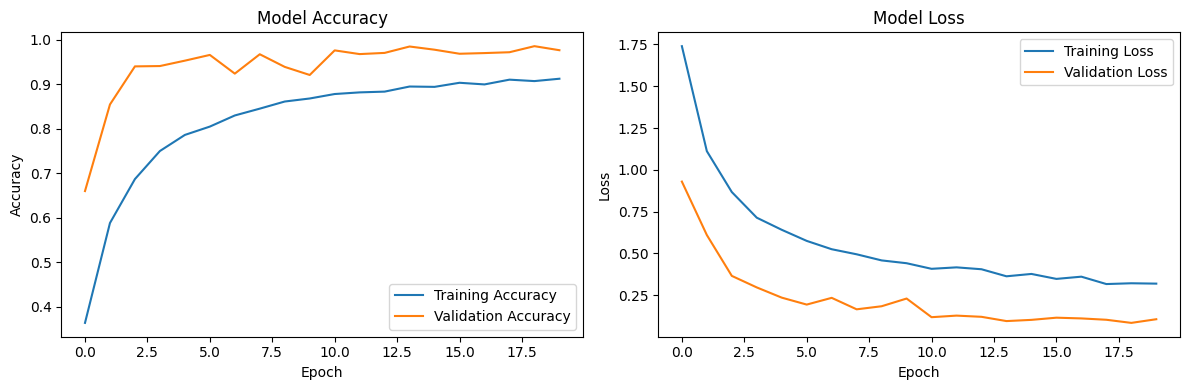

In [58]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('loss')
plt.show()

<Figure size 1200x1000 with 0 Axes>

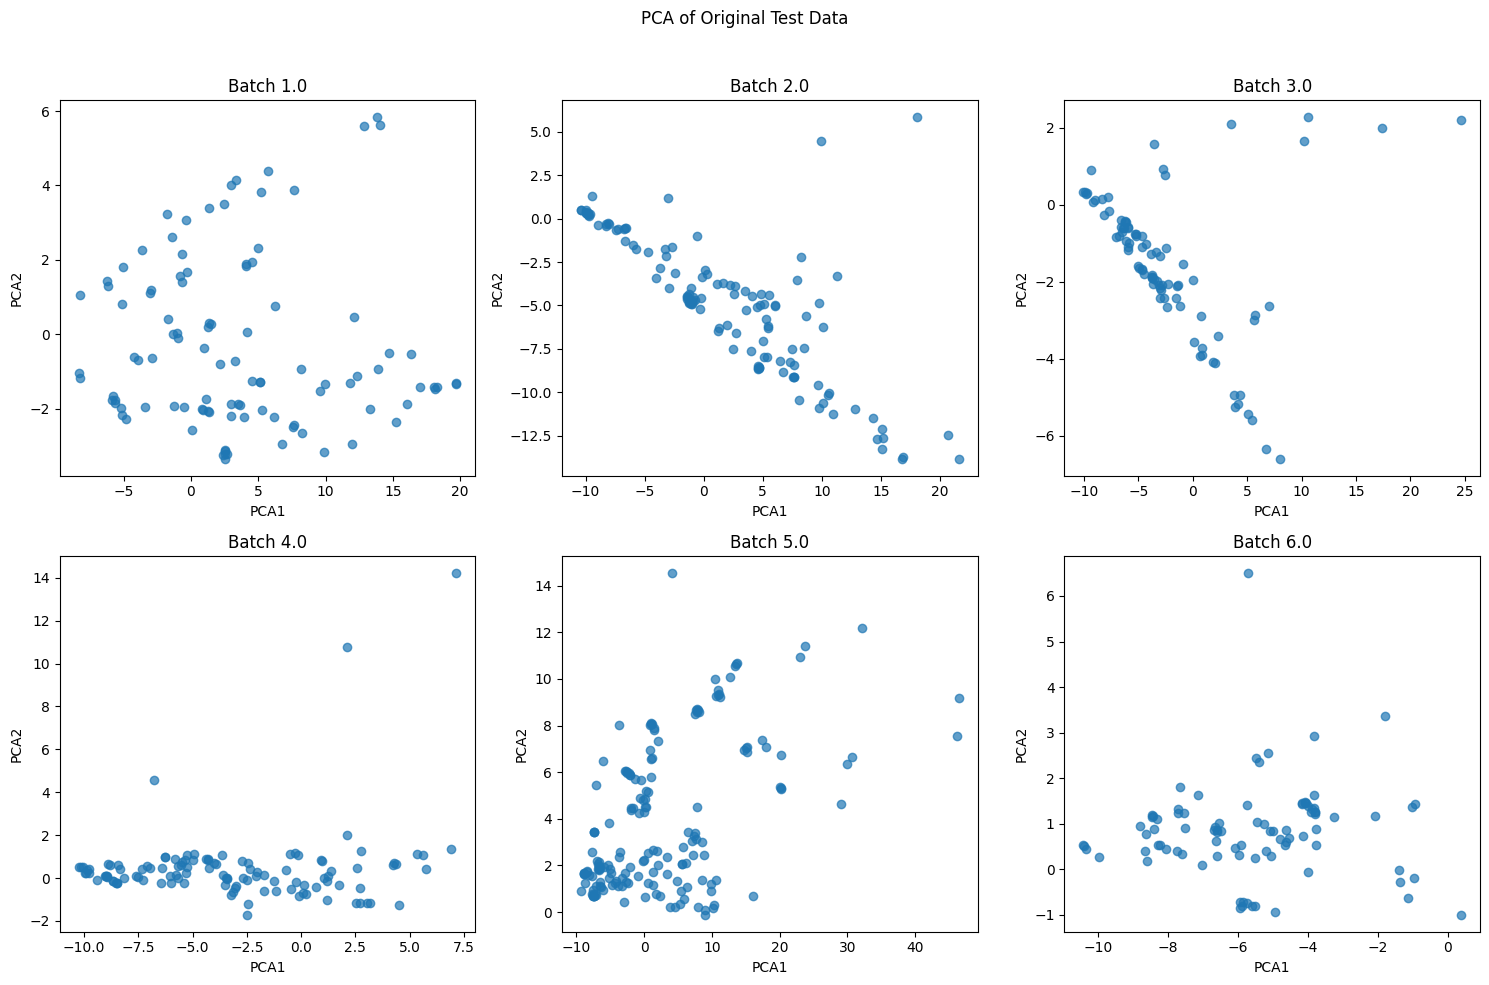

<Figure size 1200x1000 with 0 Axes>

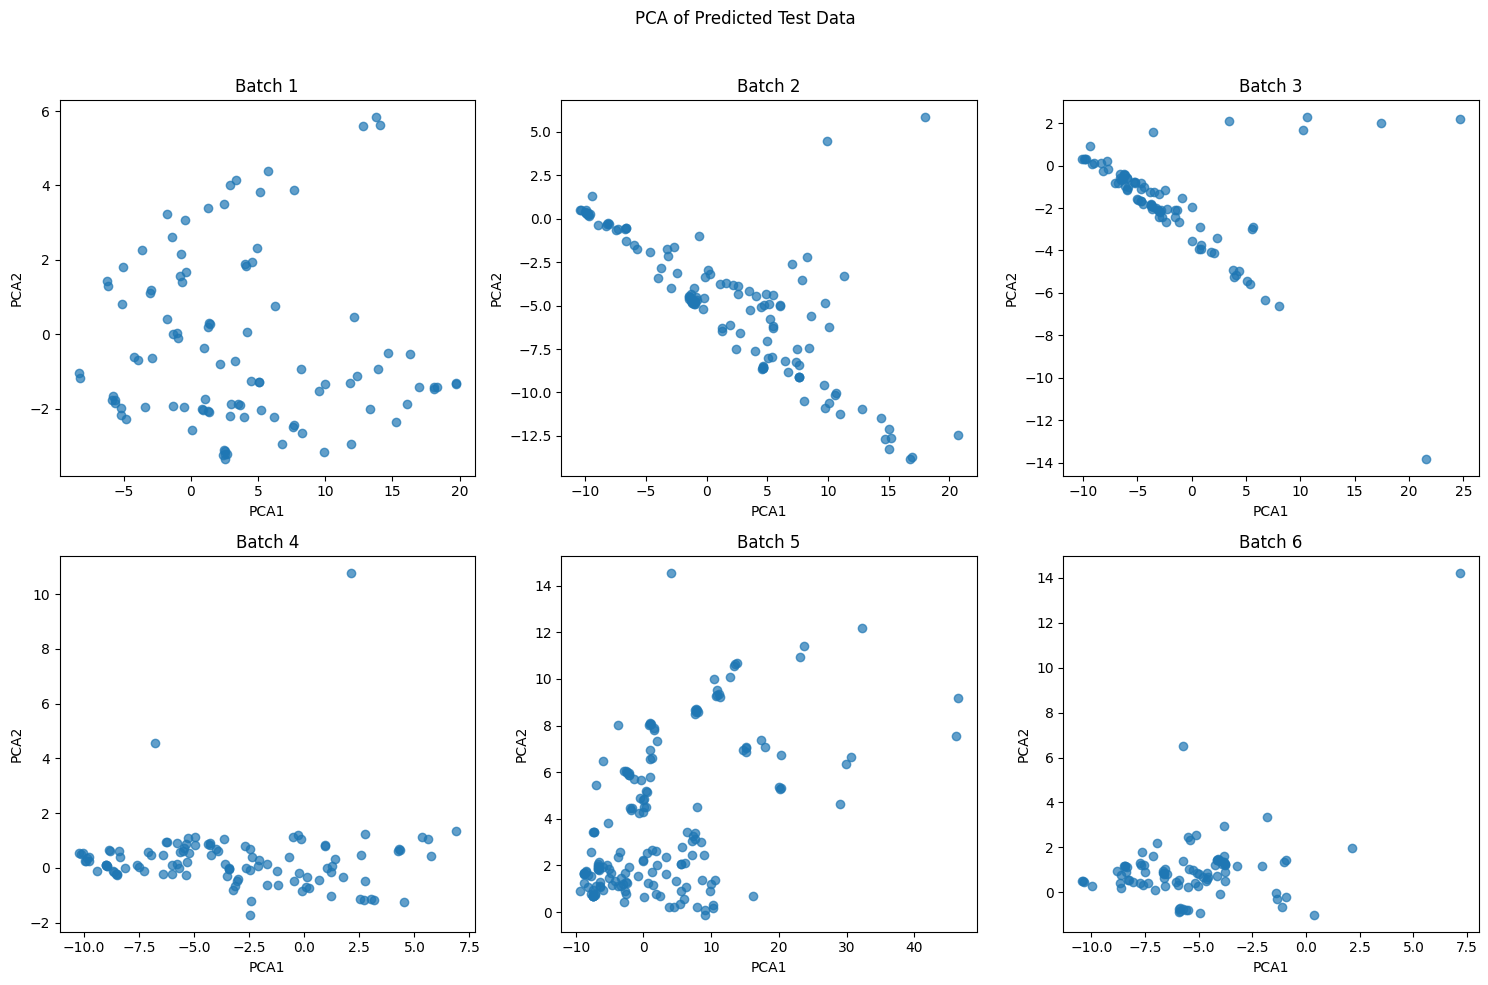

In [59]:
# Perform PCA and plot the results
def plot_pca(data, labels, title, save_path):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    
    plt.figure(figsize=(12, 10))
    unique_labels = np.unique(labels)
    n_batches = len(unique_labels)
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title)
    
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)
        ax = axs[i // 3, i % 3]
        ax.scatter(pca_result[idx, 0], pca_result[idx, 1], alpha=0.7)
        ax.set_title(f'Batch {label}')
        ax.set_xlabel('PCA1')
        ax.set_ylabel('PCA2')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path)
    plt.show()

# Case Study 1: PCA on Original Data
plot_pca(X_test_scaled, y_test, 'PCA of Original Test Data', 'pca_original_test_data.png')

# Case Study 2: PCA on Predicted Data
plot_pca(X_test_scaled, y_pred_classes, 'PCA of Predicted Test Data', 'pca_predicted_test_data.png')


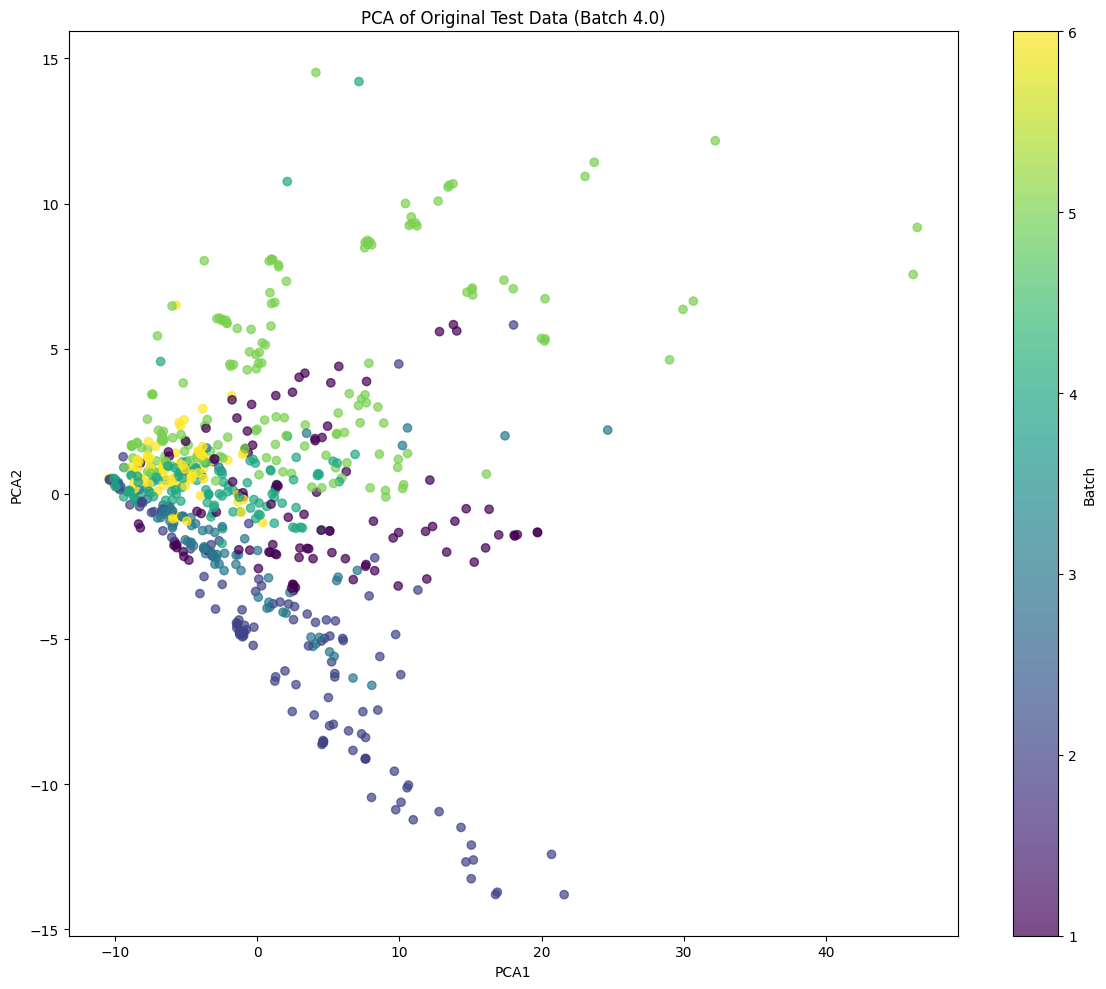

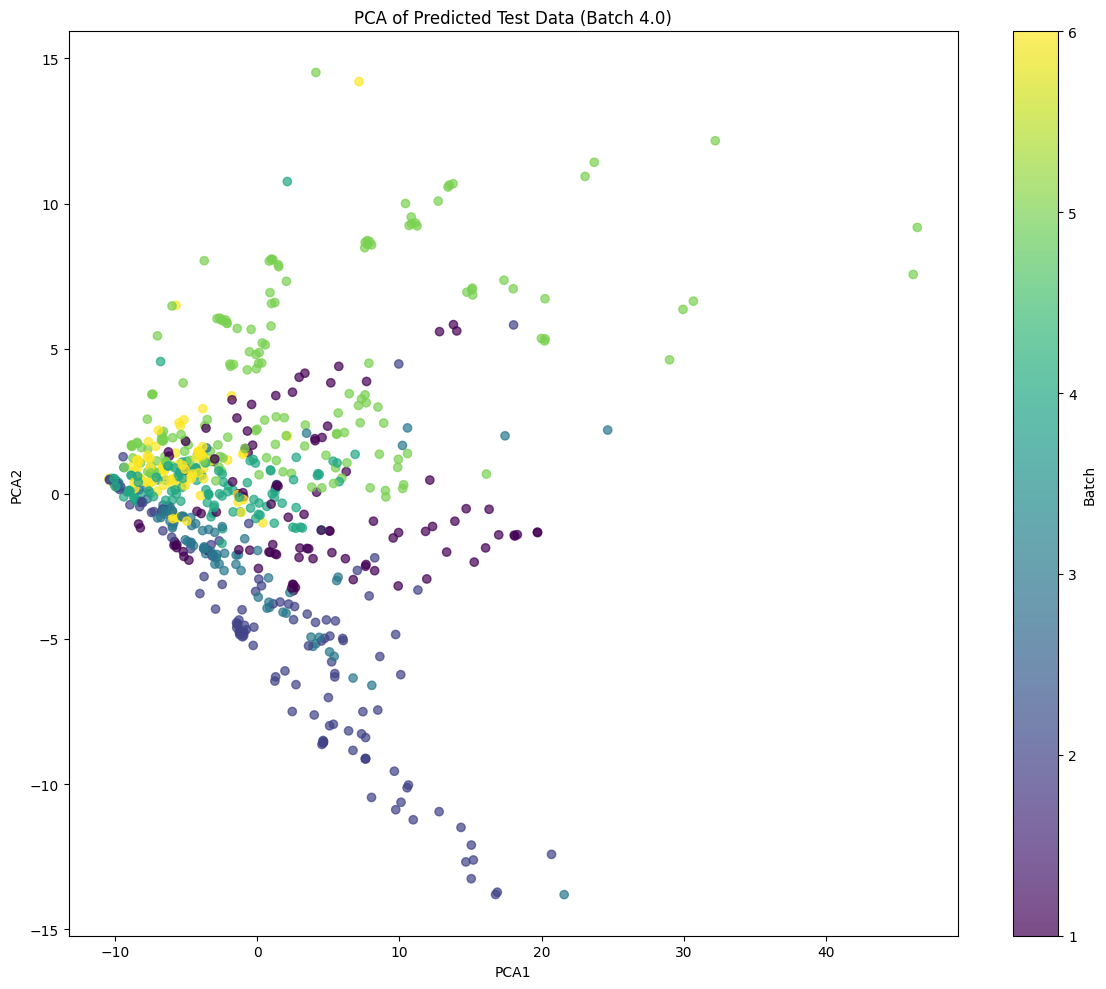

In [62]:
# Perform PCA and plot the results
def plot_pca(data, labels, title, save_path):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    
    plt.figure(figsize=(12, 10))
    
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Batch')
    plt.title(title)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Case Study 1: PCA on Original Data
plot_pca(X_test_scaled, y_test, f'PCA of Original Test Data (Batch {y_test.iloc[0]})', 'pca_original_test_data.png')

# Case Study 2: PCA on Predicted Data
plot_pca(X_test_scaled, y_pred_classes, f'PCA of Predicted Test Data (Batch {y_test.iloc[0]})', 'pca_predicted_test_data.png')
